In [ ]:
import os
import sys
import json
import skimage.io
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt
import random
import math
import re, time
import matplotlib
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!git clone --quiet "https://github.com/ahmedfgad/Mask-RCNN-TF2.git"

In [ ]:
%%capture
!unzip "/content/drive/MyDrive/crane_handle_.zip" -d "/content/Mask-RCNN-TF2"

In [ ]:
ROOT_DIR = os.path.abspath("../../content/Mask-RCNN-TF2")

In [ ]:
import h5py, tensorflow, keras
print(h5py.__version__)

3.1.0


In [ ]:
print(tensorflow.__version__)

2.2.0


In [ ]:
print(keras.__version__)

2.3.1


In [ ]:
!pip install -r ./Mask-RCNN-TF2/requirements.txt #change h5py==2.10.0 tensorflow==2.6.0 keras==2.0.8

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 377 kB 51.0 MB/s 
     |████████████████████████████████| 2.9 MB 39.4 MB/s 
     |████████████████████████████████| 3.0 MB 40.1 MB/s 
     |████████████████████████████████| 454 kB 51.6 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 154 kB 51.1 MB/s 
     |████████████████████████████████| 391 kB 51.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting 

In [ ]:
sys.path.append(ROOT_DIR)

In [ ]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/Mask_RCNN']

In [ ]:
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.visualize import display_images
from mrcnn import model as modellib, utils
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
#Path to trained weight file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

#Dir to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

CUSTOM_DIR = os.path.join(ROOT_DIR, "crane_handle_")

INFERENCE_IMG_PATH = "/content/WhatsApp Image 2021-10-14 at 5.45.41 PM.jpeg" #path to the image that will be used for inference

WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/mask_rcnn_object_0004.h5" #path to the last trained weight

In [ ]:
#Configurations

class CustomConfig(Config):
  """
  Building configuration for the crane datasets. 
  from base Config class and overrides some values.
  """

  #configuration name
  NAME = "object"

  IMAGES_PER_GPU = 1 #TODO: Change to 2 for training and 1 for inference

  NUM_CLASSES = 1 + 1 #background + crane

  #Number of training steps per epoch
  STEPS_PER_EPOCH = 20

  #Skip detection with < 80% confidence 
  DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class CustomDataset(utils.Dataset):

  def load_custom(self, dataset_dir, subset):
    """
    Load a subset of the crane dataset

    Args:
    dataset_dir: root directory of the dataset
    subset: the subset of the dataset to load either train or val

    Return:
    None
    """

    #Add classes, since we only have oone class
    self.add_class("object", 1, "crane handle")

    #train or validation dataset
    assert subset in ['train', 'val']
    dataset_dir = os.path.join(dataset_dir, subset)

    #Load annotations
    #since we only care about the x and y coordinate of each regions
    annotations1 = json.load(open(os.path.join(dataset_dir, "Crane_json.json")))

    #print annotations
    annotations = list(annotations1.values()) #we don't need the dictionary keys

    #skipping unannotated images
    annotations = [a for a in annotations if a['regions']]

    #add images
    for a in annotations:
      #get the x, y coordinates of points of the polygon that makes up the
      #outline of each object instances

      polygons = [r['shape_attributes'] for r in a['regions']]
      #name is from the header of the labeling tool
      objects = [s['region_attributes']['name'] for s in a['regions']]
      #print("objects", objects)

      name_dict = {"crane handle" : 1}
      num_ids = [name_dict[a] for a in objects]

      #print("numids", num_ids)

      image_path = os.path.join(dataset_dir, a['filename'])
      image = skimage.io.imread(image_path)
      height, width = image.shape[:2]

      self.add_image(
          "object",
          image_id = a['filename'],
          path = image_path,
          width = width,
          height = height,
          polygons = polygons,
          num_ids = num_ids
      )

  def load_mask(self, image_id):
    """
    It generate instance mask for an image

    Args:
    image_id: 

    Returns:
    mask: a boll array of shape [heaight, width, instance count] with one mask 
    per image
    class_ids: a 1D array of class IDs of the instance masks.
    """

    # if not a crane dataset image, delegate to parent class
    image_info = self.image_info[image_id]
    if image_info['source'] != "object":
      return super(self.__class__, self).load_mask(image_id)

    #convert polygons to a bitmap mask of shape
    info = self.image_info[image_id]
    if info["source"] != "object":
      return super(self.__class__, self).load_mask(image_id)
    num_ids = info['num_ids']
    mask = np.zeros([info['height'], info["width"], len(info['polygons'])],
                    dtype=np.uint8)
    for i, p in enumerate(info['polygons']):
      rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
      mask[rr, cc, i] = 1

    #return mask and array of class IDs of each instances
    num_ids = np.array(num_ids, dtype=np.int32)
    return mask, num_ids

  def image_reference(self, image_id):
    """
    Returns the path of an image
    """

    info = self.image_info[image_id]
    if info['source'] == "object":
      return info['path']
    
    else:
      super(self.__class__, self).images_reference(image_id)


In [ ]:
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """
    Return a matplotlib axes array to be used in all visulizations in the notebook
    """

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode='inference', model_dir= 'MODEL_DIR',
                         config=config)

weights_path = WEIGHTS_PATH

model.load_weights(weights_path, by_name=True)

In [ ]:
#run inference on the test images
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
                            dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info['source'], info['id'], image_id,
                                       dataset.image_reference(image_id)))

#run object detection
print(len([image]))
results = model.detect([image], verbose=1)

#Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

1
Processing 1 images
image                    shape: (682, 1023, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


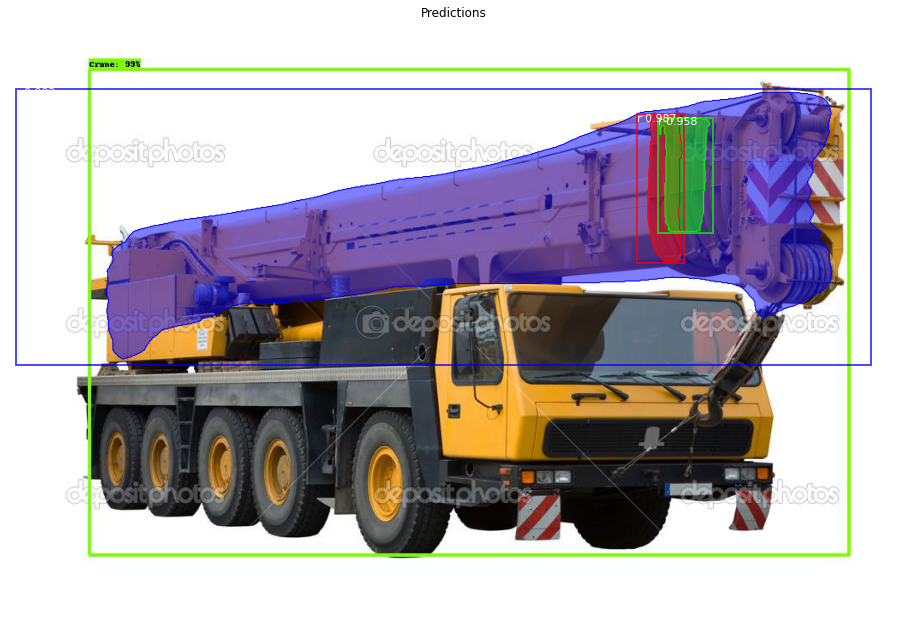

In [ ]:
#run inference on a single image

img = Image.open(INFERENCE_IMG_PATH)
if img.mode == "RGBA":
  b = Image.new("RGB", img.size, (255, 255, 255))
  b.paste(img, mask = img.split()[3])
  b.save(os.path.join(ROOT_DIR, "sample.jpg"), "JPEG")
  image1 = mpimg.imread(os.path.join(ROOT_DIR, "sample.jpg"))
else:
  image1 = mpimg.imread(INFERENCE_IMG_PATH)

print(len([image1]))
result1 = model.detect([image1], verbose=1)

class_names = 'crane handle'
ax = get_ax(1)
r1 = result1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            class_names, r1['scores'], ax=ax,
                            title="Predictions", save_fig_path = "/content/img.png")


In [ ]:
#run inference on a single image

img = Image.open(INFERENCE_IMG_PATH)
if img.mode == "RGBA":
  b = Image.new("RGB", img.size, (255, 255, 255))
  b.paste(img, mask = img.split()[3])
  b.save(os.path.join(ROOT_DIR, "sample.jpg"), "JPEG")
  image1 = mpimg.imread(os.path.join(ROOT_DIR, "sample.jpg"))
#else:
#  image1 = mpimg.imread(INFERENCE_IMG_PATH)

print(len([image1]))
result1 = model.detect([image1], verbose=1)

class_names = 'crane handle'
ax = get_ax(1)
r1 = result1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            class_names, r1['scores'], ax=ax,
                            title="Predictions")


In [ ]:
i = mpimg.imread(image1)
plt.savefig("/content/i.png")

In [ ]:
class_id = 2

images_cropped = []
class_fltr = r1['class_ids']
boxes = r1['rois'][class_fltr, :]
for box in boxes:
  y1, x1, y2, x2 = box
  cropped = image1[y1: y2, x1: x2]
  images_cropped.append(cropped)

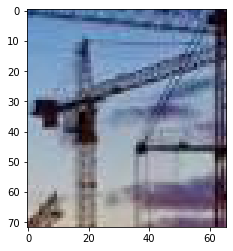

In [ ]:
#import matplotib.pyplot as plt
img = images_cropped[0]
plt.imshow(img)

In [ ]:
f_img = Image.fromarray(image1)
f_img.save("/content/j.png")

In [ ]:
!zip -r /content/mrcnn.zip /content/Mask-RCNN-TF2/mrcnn

  adding: content/Mask-RCNN-TF2/mrcnn/ (stored 0%)
  adding: content/Mask-RCNN-TF2/mrcnn/config.py (deflated 59%)
  adding: content/Mask-RCNN-TF2/mrcnn/model_temp.py (deflated 76%)
  adding: content/Mask-RCNN-TF2/mrcnn/parallel_model.py (deflated 63%)
  adding: content/Mask-RCNN-TF2/mrcnn/model.py (deflated 76%)
  adding: content/Mask-RCNN-TF2/mrcnn/utils.py (deflated 71%)
  adding: content/Mask-RCNN-TF2/mrcnn/visualize.py (deflated 71%)
  adding: content/Mask-RCNN-TF2/mrcnn/__init__.py (stored 0%)


In [ ]:
!unzip /content/mrcnn.zip -d /content/

[REF_1](https://www.youtube.com/watch?v=t1MrzuAUdoE&t=1160s)

[RER_2](https://thebinarynotes.com/how-to-train-mask-r-cnn-on-the-custom-dataset/)